# Nighttime "truecolor" for GOES-16

May 19, 2019  
Jason Hickey  
[github](https://github.com/jyh/goes_truecolor)

I recently saw two presentations, where,
1. V. Lakshmanon showed how to predict lightning from weather satellite images [presentation](http://bit.ly/ams-cloud-deep-learning) [github](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/blogs/lightning), using Google cloud platform, and,
2. David John Gagne and has an awesome tutorial on [machine learning for tornado prediction](https://github.com/djgagne/ams-ml-python-course).

In this project I bring these ideas together to generate "truecolor" GOES imagery.  This is an example of the application of machine learning to weather satellite imagery.  Feel free to reuse it (under the Apache license).

The [GOES-16](https://en.wikipedia.org/wiki/Geostationary_Operational_Environmental_Satellite) weather satellite is operated by  operated by [NASA](https://en.wikipedia.org/wiki/NASA) and the National Oceanic and Atmospheric Administration ([NOAA](https://en.wikipedia.org/wiki/National_Oceanic_and_Atmospheric_Administration)).  It is positioned over South America, providing imagery of North and South America in 16 multispectral channels.  There are 2 optical bands (blue and red), 5 near-infrared bands, and 10 infrared bands.  Data is publicly available on the [Google cloud platform](https://console.cloud.google.com/marketplace/details/noaa-public/goes-16?filter=category:science-research&id=5babd633-afa0-4e40-9dba-0587f4aabc47) and free to use.

## Color composites

 By "truecolor" we really mean "color composite."  The satellite provides no green band, so for a full color image, we need to synthesize the green channel.  Here is an official truecolor composite image created by synthisizing the green band.  Beautiful, isn't it!  Look at the beautiful greens the the Amazon.  Where did they come from?  The image on the left is from May 19, 2019 at 17:30UTC, when the sun is directly behind the satellite.  The image on the right is taken 5 hours earlier, when only half the hemisphere is illuminated.
 
<table>
  <tr>
    <td>
<img src="https://docs.google.com/uc?export=download&id=1yT0UN86cFZ9AZe4lMpjqGx8L8tS5R7U1">
    <td>
<img src="https://docs.google.com/uc?export=download&id=1wTwWtMWrs6hDl1iYBUgCo6jF1NpMUJEN">
   </tr>
</table>
 
A fair amount of processing was needed to create that truecolor image, especially contrast enhacement.  The actual image as viewed by the satellite is considerably washed out.  Here is what we actually see from space.

<table>
  <tr>
    <td>
<img src="https://docs.google.com/uc?export=download&id=1jmPiHgzq8MOcqrXUa_0yv_RPTHWVPy_b">
    <td>
<img src="https://docs.google.com/uc?export=download&id=1bv5W_d7op5gymh4aVZ-faWNJ6WU1U3GW">
   </tr>
</table>

## Objective

Our objective in this project is to produce beautiful, saturarated, color composite images at all times, day and night. Since the ground changes only very slowly, we'll actually only infer the cloud cover, and overlay it on a static mask of the ground (the NASA "blue marble" images).  Here are the result images for this project, for the same times.  You can see that we now have a reasonable full disk representation on the right, even though half the image is in darkness.

<table>
  <tr>
    <td>
<img src="https://docs.google.com/uc?export=download&id=1ZkV4DCMMJOLZFiAAFv2OlY6r376fzdeX">
    <td>
<img src="https://docs.google.com/uc?export=download&id=1fUYI1iLkmKH0tzt2qJ033f_STOzVeys8">
   </tr>
</table>


Concretely, we'll do the following.

+ Explore the GOES-16 dataset ([Truecolor_1](https://colab.research.google.com/drive/1y0N03UwmJvHiUy4V4mcQajDFLPbADJJa?authuser=2#scrollTo=ucxnZ9PISG7Z) colab).
+ Extract Tensorflow examples with a beam pipeline.
+ Train a Tensorflow/Keras model in Google colab ([Trucolor_2](https://colab.research.google.com/drive/1W-b5FsmDMecpLNYE5r6y3VMay4udnJu3?authuser=2#scrollTo=zzZSrQiNI_l7)).
+ Use the model to infer cloud masks ([Truecolor_3](https://colab.research.google.com/drive/1X_cqInqx_QjelsScxWnM53PxMhB-5mM4?authuser=2#scrollTo=ybQcD7NQj_eF) colab) as well as a beam pipeline on Google cloud platform.

If you want to follow along and run all the examples, you will need to create an account on Google Compute Engine.  All code executes on GCP, you can run everything from your browser.  The cost is about $10 if you want to reproduce this project and execute all of the GCP code.  Otherwise, you can view this project for free.

# Preparation

(Based on [Lak's lightning project](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/blogs/lightning/README.md)).  To reproduce, follow these steps:

1. Open CloudShell following the directions in https://cloud.google.com/shell/docs/quickstart -- this gives you a free 
temporary VM. If you want something more permanent, start a Compute Engine instance or install the gcloud SDK to your laptop following the directions in https://cloud.google.com/sdk/install

2. Install the necessary Python packages:
```
sudo pip install -U absl-py apache_beam[gcp] dateparser netcdf4 xarray pyresample "google-api-core>=1.11" "google-cloud-core>=1" "google-cloud-storage>=1.16" scikit-image tensorflow
```

3. Git clone this repository and cd into it:
```
git clone https://github.com/jyh/goes_truecolor.git
cd goes_truecolor
```

4. Create a bucket to store your outputs if necessary following steps in https://cloud.google.com/storage/docs/creating-buckets

# Colab setup

Setup for this colab.

In [0]:
!pip install -U -q dateparser netcdf4 xarray pyresample "google-api-core>=1.11" "google-cloud-core>=1" "google-cloud-storage>=1.16" scikit-image tensorflow

from google.colab import auth
auth.authenticate_user()

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from typing import Any, Callable, Dict, List, Optional, Text, Tuple, Union

import collections
from contextlib import contextmanager
import datetime
import dateutil.tz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pyresample
import re
import skimage 
import skimage.transform
import tempfile
import urllib
import xarray

import google.cloud.storage as gcs

PROJECT_ID = 'weather-324'
GOES_BUCKET = 'gcp-public-data-goes-16'
UTC = dateutil.tz.tzutc()

# https://visibleearth.nasa.gov/view.php?id=73909
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x10800.png'
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg'

# Metadata fields to save from each imager file.
METADATA_KEYS = [
    'x',
    'y',
    'kappa0',
    'band_id',
    'x_image_bounds',
    'y_image_bounds',
    'goes_imager_projection',
    'time_coverage_start',
]

IR_SCALE_FACTOR = [
    1e-2,  # 0
    1e-2,  # 1
    1e-2,  # 2
    1e-2,  # 3
    1e-2,  # 4
    1e-2,  # 5
    1e-2,  # 6
    1e-2,  # 7
    1 / 10, # 8
    1 / 20,  # 9
    1 / 30,  # 10
    1 / 100,  # 11
    1 / 100,  # 12
    1 / 150,  # 13
    1 / 150,  # 14
    1 / 150,  # 15
    1 / 150,  # 16
]

# Processing GOES files

We a class GoesReader containing the basic GOES I/O operations.

## Filenames

GOES-16 files are stored on GCP as the original NetCDF4 files provided by NOAA.  Full disk images are taken every 15 minutes.  Each channel is stored in a file with a filename containing both the channel number and the date.  So, for example, a listing of channels files for January 1, 2019 17:00UTC looks like the following.

    ABI-L1b-RadF/2019/001/17/OR_ABI-L1b-RadF-M3C01_G16_s20190011700364_e20190011711130_c20190011711176.nc
    ABI-L1b-RadF/2019/001/17/OR_ABI-L1b-RadF-M3C02_G16_s20190011700364_e20190011711130_c20190011711166.nc
    ABI-L1b-RadF/2019/001/17/OR_ABI-L1b-RadF-M3C03_G16_s20190011700364_e20190011711130_c20190011711177.nc
    ABI-L1b-RadF/2019/001/17/OR_ABI-L1b-RadF-M3C04_G16_s20190011700364_e20190011711130_c20190011711163.nc
    ABI-L1b-RadF/2019/001/17/OR_ABI-L1b-RadF-M3C04_G16_s20190011715364_e20190011726130_c20190011726162.nc
    ...
    ABI-L1b-RadF/2019/001/18/OR_ABI-L1b-RadF-M3C16_G16_s20190011800364_e20190011811142_c20190011811198.nc


The ABI-L1b-RadF prefix means that this is the Advanced Base Imager (ABI), Level 1b, Radiance, and F for full-disk.  The filename itself has the form <year>/<day-of-year>/<hour>/OR_ABI-L1b-RadF-M3C<channel>_G16_s<start-date>_e<end-date>_c<creation-date>.nc.  The full disk image is square, with dimensions varying by 10088x10088 pixels for channel 1.
  
These are huge images!  That corresponds to about 1km resolution at the equator for channel 1 (blue), 0.5km resolution for channel 2 (red), and 2km resolution for the IR channels.  The imaging is performed in multiple steps, by scanning the full disc using a gimbal.
  
The _parse_filename() function parses a filename in the standard format and returns the parts as a tuple.
 


  

In [31]:
FILE_REGEX = (r'.*/OR_([^/]+)-M(\d+)C(\d\d)_G\d\d_s(\d+)(\d)'
              r'_e(\d+)(\d)_c(\d+)(\d)[.]nc')

GoesFile = collections.namedtuple('GoesFile', [
    'path', 'product', 'mode', 'channel',
    'start_date', 'end_date', 'creation_date'
])

def _parse_filename(filename: Text) -> GoesFile:
    """Convert a filename to a GoesFile description.

    Args:
      filename: string name of the file

    Returns:
      A GoesFile tuple corresponding to the filename

    Raises:
      ValueError: if the filename does not have the expected format.
    """
    m = re.match(FILE_REGEX, filename)
    if not m:
      raise ValueError(
          'Goes filename does not match regular expression: ' + filename)
    product = m.group(1)
    mode = int(m.group(2))
    channel = int(m.group(3))
    start_date = datetime.datetime.strptime(m.group(4), '%Y%j%H%M%S')
    start_date += datetime.timedelta(milliseconds=100 * int(m.group(5)))
    start_date = start_date.replace(tzinfo=UTC)
    end_date = datetime.datetime.strptime(m.group(6), '%Y%j%H%M%S')
    end_date += datetime.timedelta(milliseconds=100 * int(m.group(7)))
    end_date = end_date.replace(tzinfo=UTC)
    creation_date = datetime.datetime.strptime(m.group(8), '%Y%j%H%M%S')
    creation_date += datetime.timedelta(milliseconds=100 * int(m.group(9)))
    creation_date = creation_date.replace(tzinfo=UTC)
    return GoesFile(filename, product, mode, channel, start_date, end_date,
                    creation_date)
  
_parse_filename('ABI-L1b-RadF/2019/001/17/OR_ABI-L1b-RadF-M3C04_G16_s20190011715364_e20190011726130_c20190011726162.nc')

GoesFile(path='ABI-L1b-RadF/2019/001/17/OR_ABI-L1b-RadF-M3C04_G16_s20190011715364_e20190011726130_c20190011726162.nc', product='ABI-L1b-RadF', mode=3, channel=4, start_date=datetime.datetime(2019, 1, 1, 17, 15, 36, 400000, tzinfo=tzutc()), end_date=datetime.datetime(2019, 1, 1, 17, 26, 13, tzinfo=tzutc()), creation_date=datetime.datetime(2019, 1, 1, 17, 26, 16, 200000, tzinfo=tzutc()))

## NetCDF and temporary files

The python netCDF4 library isn't able to read files directly from cloud storage, so before processing each file, we copy it to a local directory containing temporary files.

In [0]:
@contextmanager
def mktemp(**keyword_params):
  """Create a local file, removing it when the operation is complete.

  Args:
    **keyword_params: keyword params to be passed to tempfile.mkstemp().

  Yields:
    Filename of the temporary file.
  """

  fd, local_filename = tempfile.mkstemp(**keyword_params)
  os.close(fd)
  yield local_filename
  os.remove(local_filename)

## The GoesReader class

We implement the GOES I/O in a class GoesReader.

+ The `reader.list_time_range(start_time, end_time)` returns a list of GCS blobs (files) for GOES images within the time range.
+ The `reader._load_image(blob)` takes a GCS blob, copies it to a local temporary file, then load the file into memory as an `xarray.DataArray`.  It returns a resampled, quantized, image.
+ The `reader._resample_image(nc)` takes a raw image and resamples it to the desired resolution, and converts it to a grayscale image.  To save space, we quantize the output to `np.uint8`.
+ The methods `reader.load_channel_images(t, channels)` load a set of channels for a specified dat.
+ The method `reader.load_world_image_from_url(url, grid)` fetches a image of the world from a URL, and resamples it to match the GOES full-disk images, using pyresample to perform the resampling.  The NASA Blue Marble images are represented with a flat equally-spaced latitude/longitude representation.

In [0]:
def resample_world_img(
    world_img: np.ndarray,
    new_grid: pyresample.geometry.AreaDefinition) -> np.ndarray:
  """Resample an image of the world to fit a pyresample area.

  Args:
    world_img: a flat image with lat/lng extent (-180, 180, 90, -90).
    new_grid: the desired resampling grid.

  Returns:
    A resampled image.
  """
  h, w = world_img.shape[:2]
  lats = np.linspace(90, -90, h)
  lons = np.linspace(-180, 180, w)
  mesh_lons, mesh_lats = np.meshgrid(lons, lats)
  base_grid = pyresample.geometry.GridDefinition(
      lons=mesh_lons, lats=mesh_lats)
  return pyresample.kd_tree.resample_nearest(
      base_grid, world_img, new_grid,
      radius_of_influence=50000)

class GoesReader(object):
  """Client for accessing GOES-16 data."""

  def __init__(self, project_id: Text, goes_bucket_name: Text = GOES_BUCKET, key: Text = 'Rad', shape: Tuple[int, int] = (1024, 1024)):
    """Create a GoesReader.
    
    Args:
      project_id: the GCS project ID (for billing)
      goes_bucket_name: the GCS GOES bucket name (defaults to GOES-16)
      key: the data field (default 'Rad')
      shape: desired image shape
    """
    self.project_id = project_id
    self.goes_bucket_name = goes_bucket_name
    self.client = gcs.Client(project=project_id)
    self.tmp_dir = tempfile.mkdtemp('GoesReader')
    self.key = key
    self.shape = shape
    self.cache = {}
    self.world_imgs = {}

  def list_time_range(
      self, start_time: datetime.datetime, end_time: datetime.datetime) -> List[Tuple[datetime.datetime, Dict[int, gcs.Blob]]]:
    """List the blobs for GOES images within the given time range.

    Args:
      start_time: the beginning of the time range.
      end_time: the end of the time range.

    Returns:
      A list of time,channels pairs, where channels is a dictionary
      mapping channel number to GCS blob.
    """
    start_time = start_time.astimezone(UTC)
    end_time = end_time.astimezone(UTC)

    bucket = self.client.get_bucket(self.goes_bucket_name)
    blobs = []
    t = start_time
    h = datetime.timedelta(hours=1)
    while t < end_time + h:
      prefix = t.strftime('ABI-L1b-RadF/%Y/%j/%H')
      blobs.extend(bucket.list_blobs(prefix=prefix))
      t += h
      
    # Index them.
    channels = {}
    for b in blobs:
      f = _parse_filename(b.id)
      if f.start_date < start_time or f.start_date >= end_time:
        continue
      channel_map = channels.setdefault(f.start_date, {})
      channel_map[f.channel] = b
    return sorted(channels.items())
  
  def _resample_image(self, nc: xarray.DataArray) -> np.ndarray:
    """Extract an image from the GOES data."""
    kappa0 = nc['kappa0'].data
    if np.isnan(kappa0):
      kappa0 = IR_SCALE_FACTOR[nc.band_id.data[0]]
    img = nc[self.key].data
    img = img.astype(np.float32) * kappa0
    img = np.nan_to_num(img)
    img = np.minimum(1, np.maximum(0, img))
    img = skimage.transform.resize(img, self.shape, mode='reflect', anti_aliasing=True)
    return (img * 255).astype(np.uint8)
  
  def _load_image(self, blob: gcs.Blob) -> Tuple[np.ndarray, Dict[Text, Any]]:
    id = blob.id
    if id in self.cache:
      return self.cache[id]
    with mktemp(dir=self.tmp_dir, suffix='.nc') as infile:
      blob.download_to_filename(infile)
      with xarray.open_dataset(infile) as nc:
        img = self._resample_image(nc)
        md = {}
        for k in METADATA_KEYS:
          if k in nc.data_vars or k in nc.coords:
            md[k] = nc[k].copy()
        v = (img, md)
        self.cache[id] = v
        return v
      
  def load_channel_images(self, t: datetime.datetime, channels: List[int]) -> Dict[int, Tuple[np.ndarray, Dict[Text, Any]]]:
    blobs = self.list_time_range(t, t + datetime.timedelta(hours=1))
    t, channel_table = blobs[0]
    imgs = {}
    for c in channels:
      if c in channel_table:
        img, md = self._load_image(channel_table[c])
      else:
        img = np.zeros(self.shape, dtype=np.float32)
        md = {}
      imgs[c] = (img, md)
    return imgs
  
  def load_world_img_from_url(self, url: Text, grid: pyresample.geometry.AreaDefinition) -> np.ndarray:
    img = self.world_imgs.get(url)
    if img is None:
      with mktemp(dir=self.tmp_dir, suffix='.jpg') as infile:
        urllib.request.urlretrieve(url, infile)
        img = skimage.io.imread(infile)
        img = resample_world_img(img, grid)
        self.world_imgs[url] = img
    return img
  
reader = GoesReader(project_id=PROJECT_ID)

# Example images

Let's look through the GOES images.

## Channel 1: Jan 1, 2019 17:00UTC

At time 17:00UTC, the sun is directly behind the satellite, and the disk is in daylight.  Let's look at channel 1 (blue).

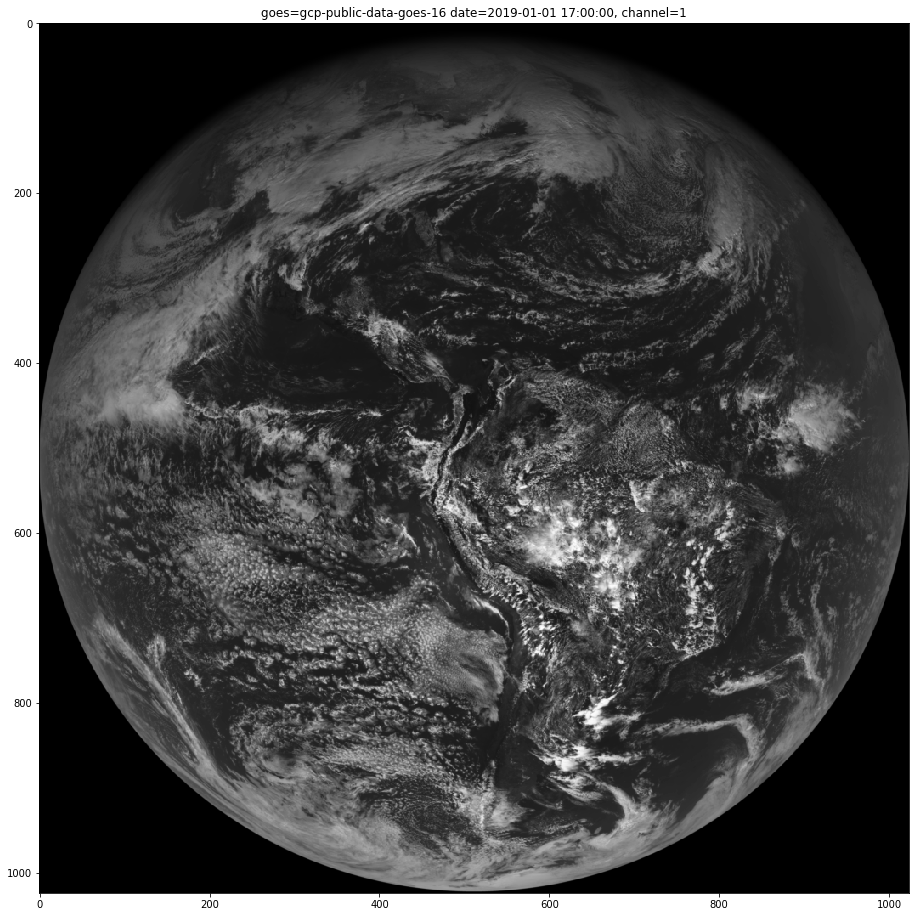

In [34]:
def show_channel_image(t: datetime.datetime, channel: int = 1, invert: bool = False):
  d = reader.load_channel_images(t, [channel])
  img, md = d[channel]
  plt.figure(figsize=(16, 16))
  if invert:
    img = 255 - img
  plt.imshow(img, cmap='gray')
  plt.title('goes={} date={}, channel={}'.format(reader.goes_bucket_name, t, channel))
  plt.show()
  
show_channel_image(datetime.datetime(2019, 1, 1, 17), channel=1)

## Channel 1: Jan 1, 2019 12:00UTC

At 12:00UTC, half the disk in in darkness.

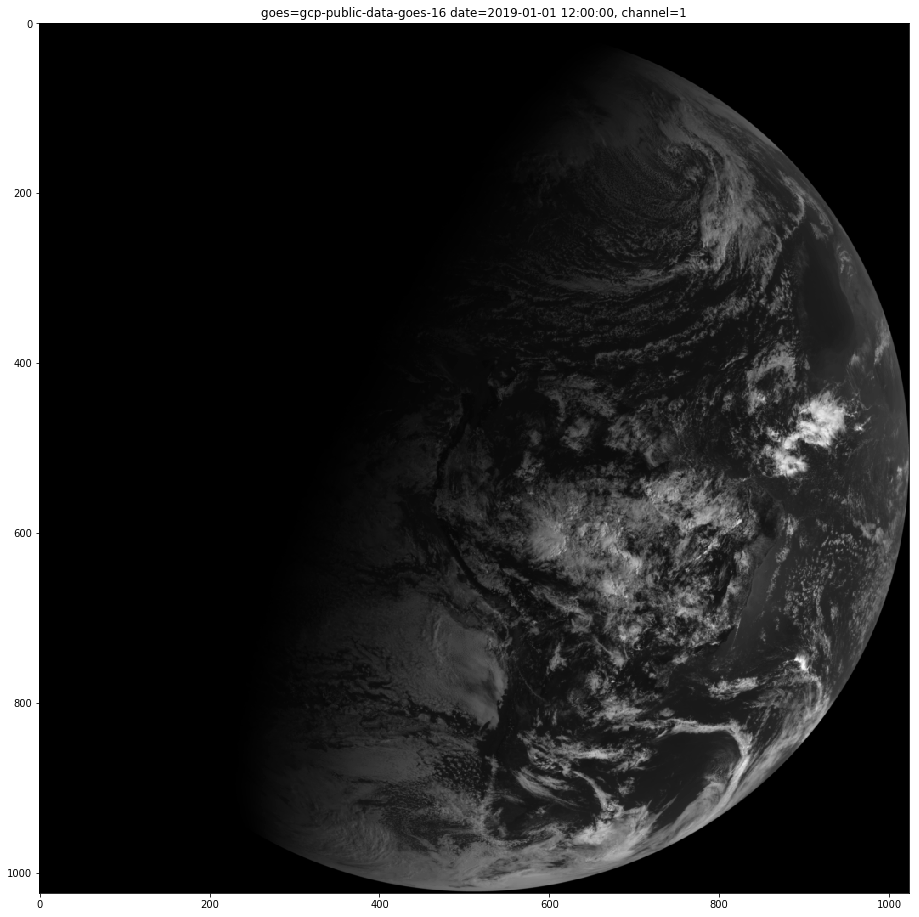

In [35]:
show_channel_image(datetime.datetime(2019, 1, 1, 12), channel=1)

## Channel 11: Jan 1, 2018 12:00UTC

The IR channels remain visible at night.  This is an image of the disk at 12:00UTC, the same time as the image above.  Note that the image looks inverted, like a negative.  In IR, the dark areas are cold (like clouds), and the bright areas are warmer.

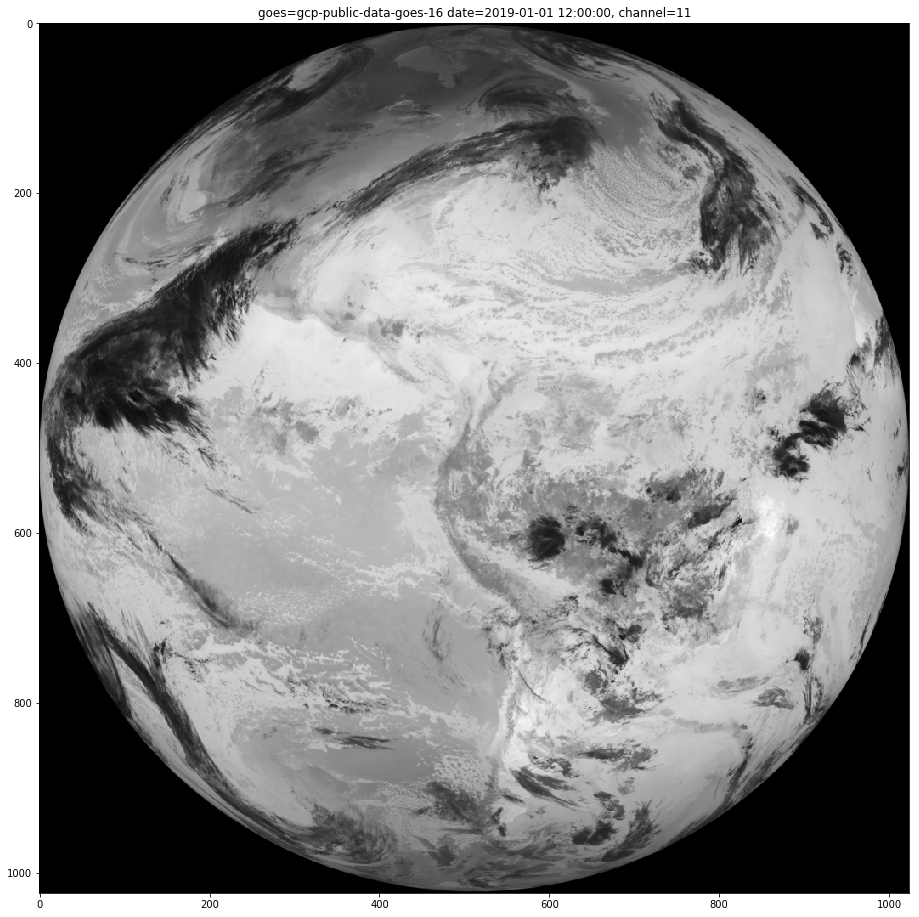

In [36]:
show_channel_image(datetime.datetime(2019, 1, 1, 12), channel=11)

# Generating "truecolor" images

The GOES satellite has only two optical bands, blue and red.  If we want a full color image, we have to synthesize a green channel.  One methods is to use the third channel (called "veggie") that is sensitive to vegetation, with the following formula.

$${\it green} = {\it blue} * 0.45 + {\it veggie} * 0.1 + {\it red} * 0.45$$

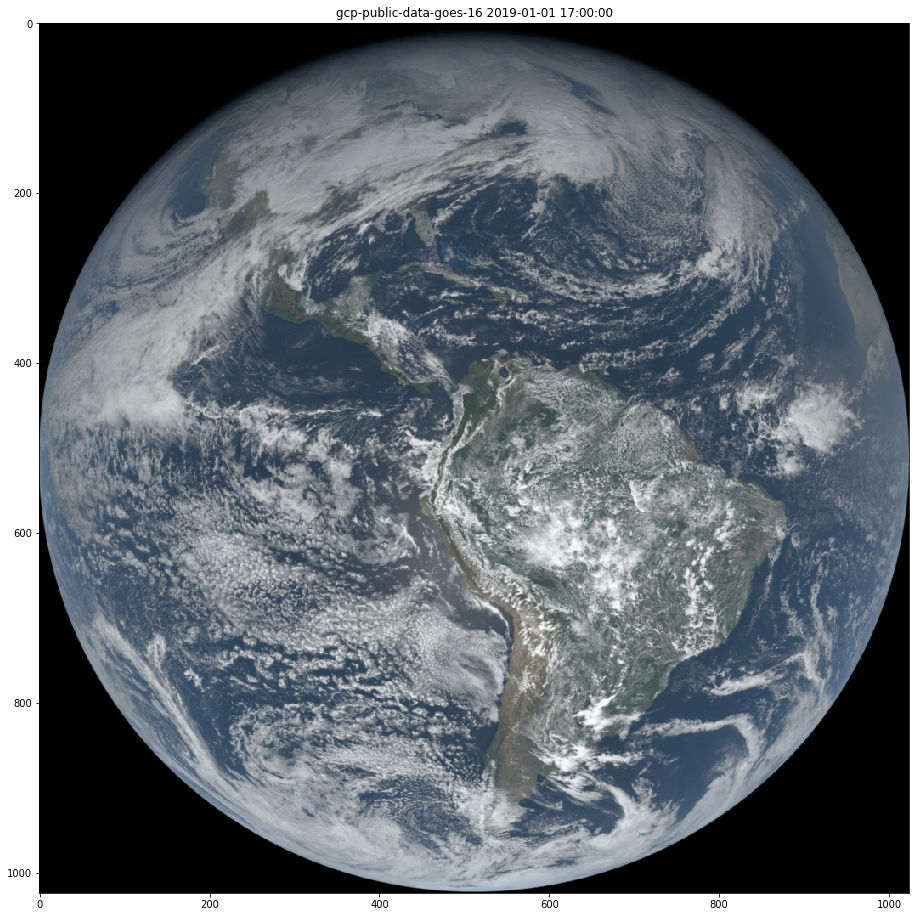

In [37]:
MAX_COLOR_VALUE = 255.9
MAX_PIXEL_VALUE = MAX_COLOR_VALUE / 256

def goes_to_daytime(ref: Dict[int, Tuple[np.ndarray, Any]]) -> np.ndarray:
  """Convert GOES channels to a truecolor image based on daytime channels.

  Args:
    ref: a dictionary of GOES channel images.

  Returns:
    A numpy RGB uint8 array with the truecolor image.
  """
  # Daytime image.
  blue, _ = ref[1]
  red, _ = ref[2]
  veggie, _ = ref[3]
  green = 0.45 * blue + 0.1 * veggie + 0.45 * red
  rgb = np.stack([red, green, blue], axis=-1)
  rgb = rgb.astype(np.float32) / 255

  # Gamma correction.
  rgb = np.sqrt(rgb)

  # Clipping.
  rgb = np.minimum(MAX_PIXEL_VALUE, np.maximum(0, rgb))
  return (rgb * 256).astype(np.uint8)


def show_daytime_image(t: datetime.datetime):
  imgs = reader.load_channel_images(t, [1, 2, 3])
  rgb = goes_to_daytime(imgs)
     
  plt.figure(figsize=(16, 16))
  plt.imshow(rgb)
  plt.title('{} {}'.format(reader.goes_bucket_name, t))
  plt.show()
  
show_daytime_image(datetime.datetime(2019, 1, 1, 17))  

## Truecolor at night

The blue, red, and veggie bands are all dark at night.

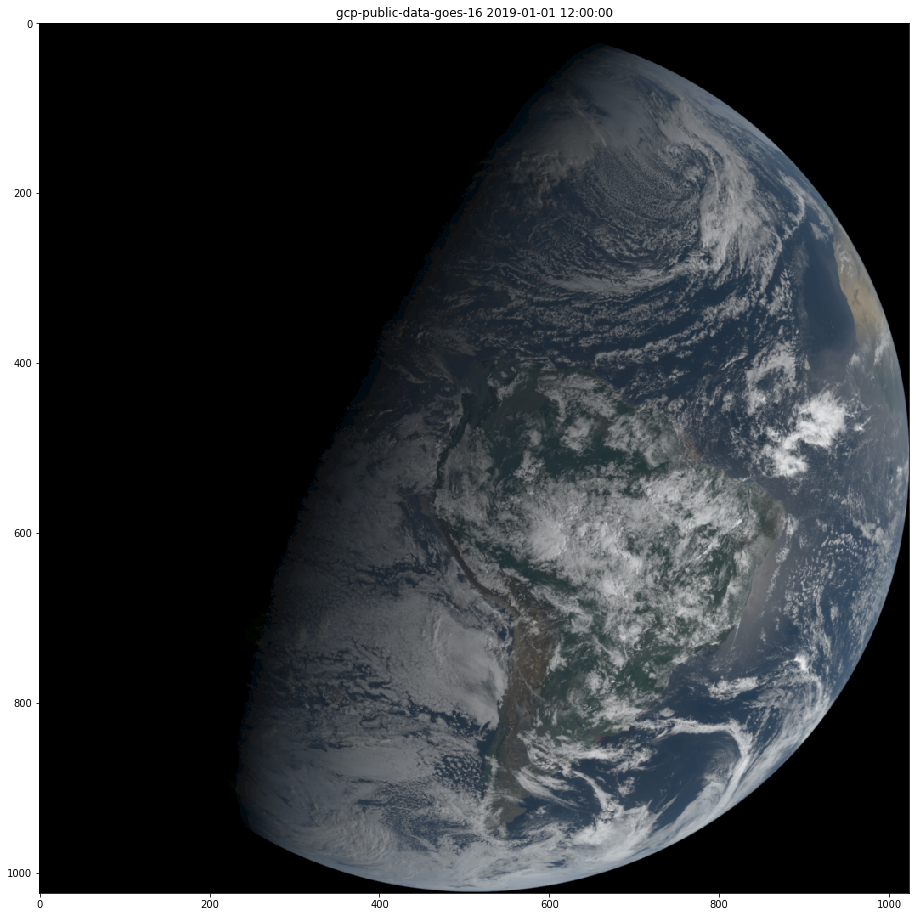

In [38]:
show_daytime_image(datetime.datetime(2019, 1, 1, 12))

# Color-composite images

Here is the idea.  Let's use the blue channel to infer a "cloud mask," overlaying the mask onto an image of the world based on NASA's blue marble.

## Loading the world map

The Blue Marble is represented in a plate-carree projection.  

![blue-marble](https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg)



## Resampling the world map

We can use `pyresample` to do the resampling.  Each GOES image contains the metadata for the full-disk projection:

+ `longitude_of_projection_origin` is the longitude of the geosyncrhonous sattelite.
+ `perspective_point_height` is the height of the satellite above the ground.
+ `x_image_bounds` and `y_image_bounds` are the bounds of the full disk image.
+ `semi_major_axis`, `semi_minor_axis`,  and `sweep_angle_axis` are all parameters of the camera gimbal.

Note that these parameters can change over time, so it is always a good idea to calculate the projection each time you fetch an image.  In fact, GOES-16 moved into its current longitude position of 75.2°W in November 17, 2017.  Prior to that, it was at a different location.

All of this can be captured in a `pyresample.AreaDefinition` that is passed to pyresample to specify the desired output image.

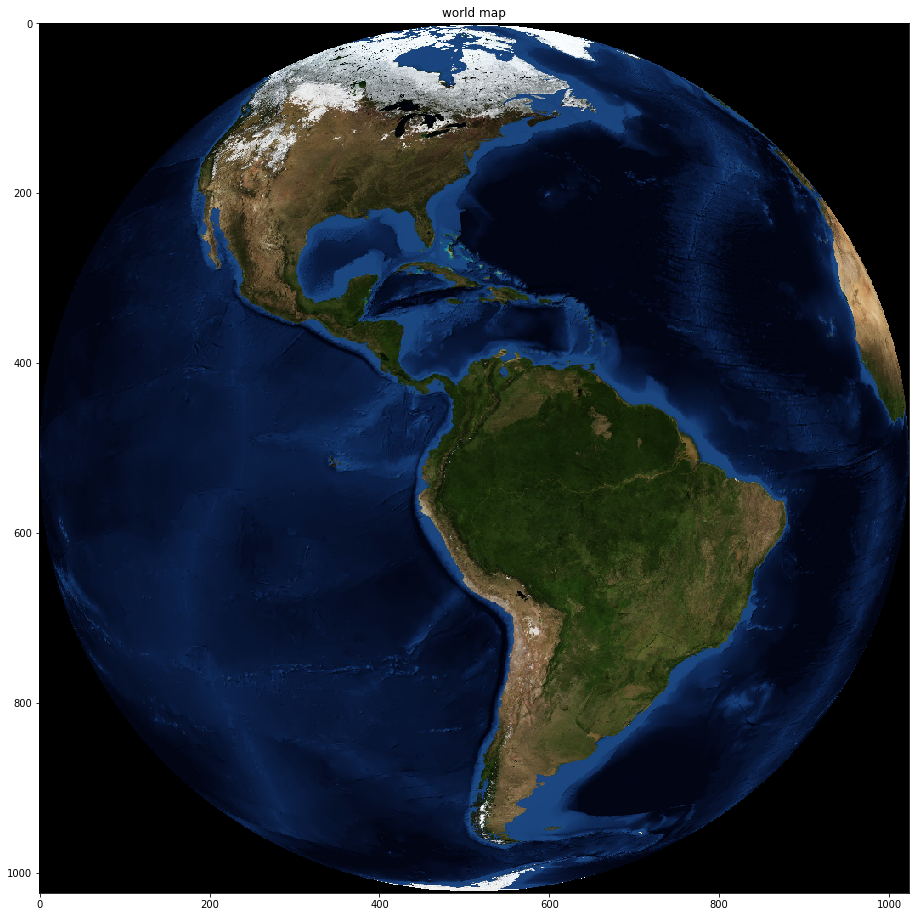

In [39]:
def goes_area_definition(md: Dict[Text, Any], shape: Optional[Tuple[int, int]] = None) -> pyresample.geometry.AreaDefinition:
  """Get the area definition for the satellite image.
  
  Args:
    md: the satellite metadata
    shape: optional shape override
    
  Returns:
    A pyresample AreaDefinition for the satellite projection.
  """
  # Dee the following references for GOES imager.
  #  Ref-1: https://proj4.org/usage/projections.html
  #  Ref-2: https://proj4.org/operations/projections/geos.html
  proj_lon_0 = md['goes_imager_projection'].longitude_of_projection_origin
  proj_h_0_m = md['goes_imager_projection'].perspective_point_height  # meters
  if shape is None:
    nx = md['x'].shape[0]
    ny = md['y'].shape[0]
  else:
    ny, nx = shape
  x1, x2 = md['x_image_bounds'].data * proj_h_0_m
  y2, y1 = md['y_image_bounds'].data * proj_h_0_m
  extents_m = [x1, y1, x2, y2]
  grid = pyresample.geometry.AreaDefinition(
    'geos',
    'goes_conus',
    'geos',
    { 'proj': 'geos',  # 'geostationary'
      'units': 'm',  # 'meters', the (same) unit for all measures here
      'h': str(proj_h_0_m),  # Ref-2, height of the view point above Earth
      'lon_0': str(proj_lon_0),  # Ref-2, longitude of the proj center
      'a': str(md['goes_imager_projection'].semi_major_axis),  # Ref-1
      'b': str(md['goes_imager_projection'].semi_minor_axis),  # Ref-1
      'sweep': str(md['goes_imager_projection'].sweep_angle_axis)  # Ref-2
    },
    nx,
    ny,
    extents_m)
  return grid

def show_world_map(t: datetime.datetime):
  imgs = reader.load_channel_images(t, [1])
  _, md = imgs[1]
  grid = goes_area_definition(md, shape=reader.shape)
  world_img = reader.load_world_img_from_url(BLUE_MARBLE, grid)
  plt.figure(figsize=(16, 16))
  plt.imshow(world_img)
  plt.title('world map')
  plt.show()
  
show_world_map(datetime.datetime(2019, 1, 1, 17))

In [0]:
import io

from PIL import Image

def save_world_map(t: datetime.datetime):
  # Get the world map
  imgs = reader.load_channel_images(t, [1])
  _, md = imgs[1]
  grid = goes_area_definition(md, shape=reader.shape)
  world_img = reader.load_world_img_from_url(BLUE_MARBLE, grid)
  
  # Convert it to JPEG
  world_img = Image.fromarray(world_img)
  buf = io.BytesIO()
  world_img.save(buf, format='JPEG', quality=70)
  buf = buf.getvalue()
  
  # Save it to cloud
  bucket = reader.client.get_bucket('weather-datasets')
  blob = bucket.blob('world_map.jpg')  
  blob.upload_from_string(buf)
  
save_world_map(datetime.datetime(2019, 1, 1, 17))

## Creating the cloud mask

During the day, we take blue channel intensity as an indication of the presence of cloud.  Let's use a soft mask using a sigmoid function.  Here is the definition of the standard sigmoid function.

$$S(x) = \frac{1}{1 + e^{-x}}$$

We actually want an image mask for values between zero and 1, so we shift and amplify the sigmoid.

$$S'(x) = \frac{1}{1 + e^{-10  (x - 0.3)}}$$

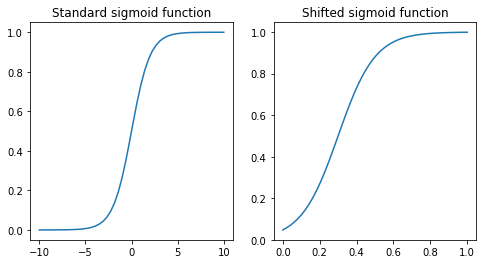

In [40]:
def plot_sigmoid():
  plt.figure(figsize=(8, 4))
  
  ax = plt.subplot(121)
  x = np.linspace(-10, 10, 50)
  y = 1 / (1 + np.exp(-x))
  ax.plot(x, y)
  plt.title('Standard sigmoid function')
  
  ax = plt.subplot(122)
  x = np.linspace(0, 1, 50)
  y = 1 / (1 + np.exp(-10 * (x - 0.3)))
  ax.plot(x, y)
  plt.title('Shifted sigmoid function')
  plt.show()
  
plot_sigmoid()


### Cloud mask composite

Now we can create a cloud mask by applying a sigmoid to the blue channel and overlay it onto the world map.  This is certainly not the same as the truecolor image, but it really looks quite good!

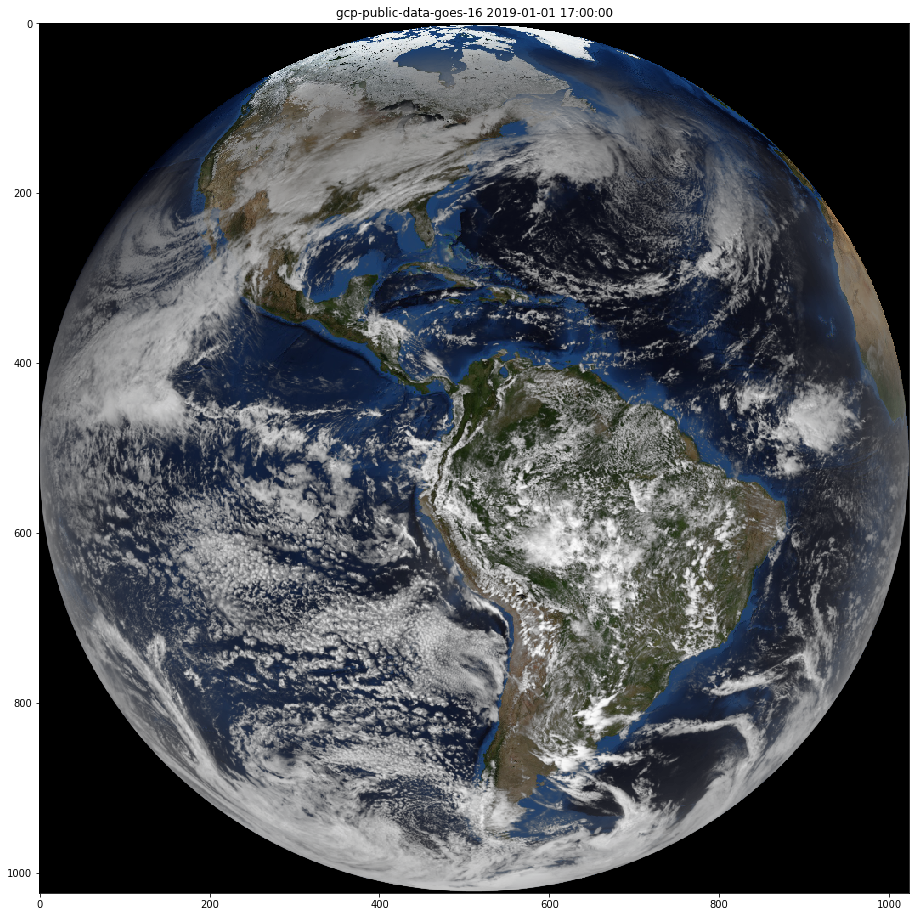

In [41]:
def cloud_mask(ref: Dict[int, Tuple[np.ndarray, Any]]) -> np.ndarray:
  """Convert GOES blue channel to a cloud mask.

  Args:
    ref: a dictionary of GOES channel images.

  Returns:
    A numpy uint8 array with the cloud mask.
  """
  blue, _ = ref[1]
  lum = np.sqrt(blue.astype(np.float32) / 256)
  mask = 1 / (1 + np.exp(-10 * (lum - 0.3)))
  return (lum * mask * MAX_COLOR_VALUE).astype(np.uint8)

def show_daytime_mask_image(t: datetime.datetime):
  ref = reader.load_channel_images(t, [1, 2, 3])
  blue, md = ref[1]
  grid = goes_area_definition(md, shape=reader.shape)
  world_img = reader.load_world_img_from_url(BLUE_MARBLE, grid)

  lum = cloud_mask(ref)
  lum = lum[:, :, np.newaxis]
  lum = lum.astype(np.float32) / 256
  mask = 1 / (1 + np.exp(-10 * (lum - 0.3)))
  world_img = world_img / 256
  img = lum * mask + (1 - mask) * world_img
     
  plt.figure(figsize=(16, 16))
  plt.imshow(img)
  plt.title('{} {}'.format(reader.goes_bucket_name, t))
  plt.show()
  
show_daytime_mask_image(datetime.datetime(2019, 1, 1, 17))  

# Next objective: infer clouds at night

As expected, there is no cloud mask at night, so the following image is has no cloud over the night region.  Let's address that in the next colab [Truecolor_2](https://colab.research.google.com/drive/1W-b5FsmDMecpLNYE5r6y3VMay4udnJu3?authuser=2#scrollTo=zzZSrQiNI_l7), using machine learning to infer the cloud mask from the IR channels.

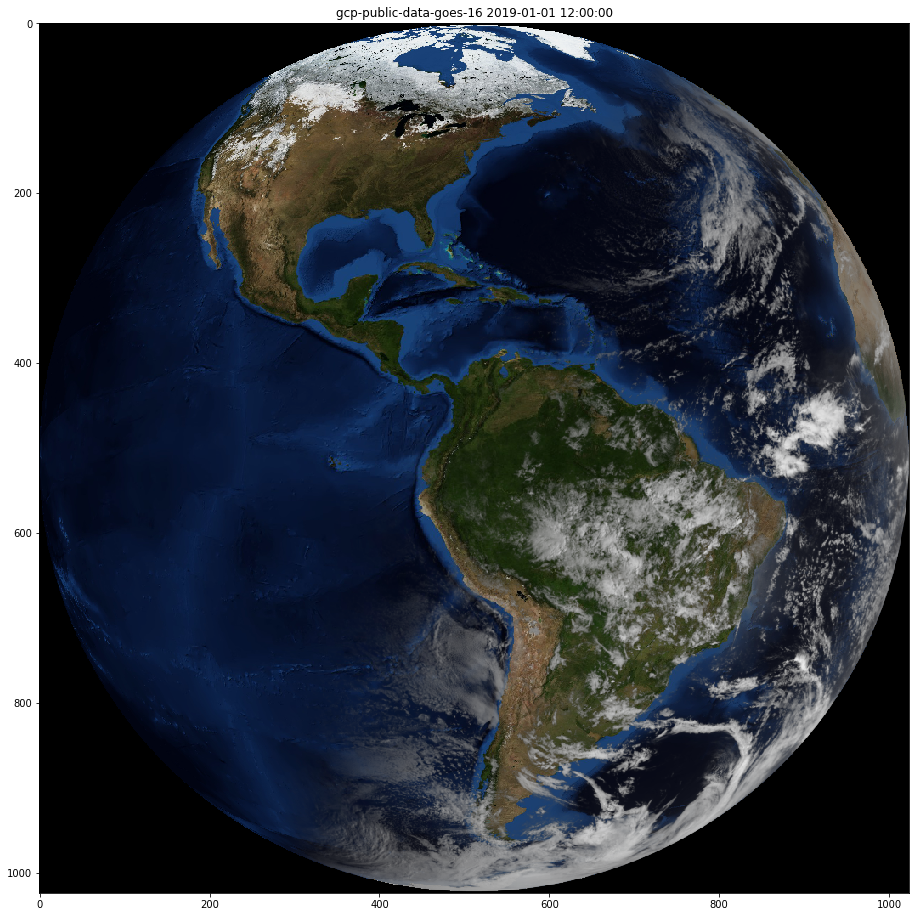

In [42]:
show_daytime_mask_image(datetime.datetime(2019, 1, 1, 12))  